In [1]:
import torch
from torchvision import datasets

In [4]:
# Path to your dataset
dataset_path = r"C:\Users\dzmit\JOB\3dnet\train_sample\images"

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [ ]:
# dataset[0][0].shape

In [6]:
# Path to your dataset
targets_path = r'C:\Users\dzmit\JOB\3dnet\train_sample\scaled'

In [7]:
import numpy as np


# transform_target = transforms.Compose([
#     # transforms.Resize((64, 64)),  # Resize all images to 64x64
#     # transforms.ToTensor(),
#     # transforms.ToFloat(),
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

def npy_loader(path):

     # Load the data from a .npy file
    sample = np.load(path)

    # Convert the numpy array from int to float32
    sample = sample.astype(np.float32)

    # Convert numpy array to a PyTorch tensor
    sample = torch.from_numpy(sample)

    # Optionally, normalize the data here if required
    # sample = (sample - sample.mean()) / sample.std()

    return sample

    # sample = torch.from_numpy(np.load(path))
    # return sample


# Create the dataset
targets = datasets.DatasetFolder(root=targets_path, loader=npy_loader, extensions=['.npy'])

In [8]:
# DataLoader
batch_size = 1  # Batch size

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
targetloader = torch.utils.data.DataLoader(targets, batch_size=batch_size, shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class To3Net(nn.Module):
    def __init__(self):
        super(To3Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 64 x 128 x 128
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 128 x 64 x 64
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Adjusting to use Conv3d
        self.decoder = nn.Sequential(
            nn.Conv3d(1, 128, kernel_size=(5, 4, 4), stride=(3, 2, 2), padding=(0, 2, 2)),
            nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=(4, 4, 4), stride=(2, 1, 1), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(128, 64, kernel_size=(4, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, 1, kernel_size=(4, 2, 2), stride=(1, 1, 1), padding=(0, 0, 0)),
            nn.Sigmoid()  # Binary output via sigmoid activation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), 1, 256, 64, 64).permute(0, 1, 2, 3, 4)  # No need for change, this reshaping was correct
        x = self.decoder(x)

        return x


In [10]:
# Train

In [11]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [12]:
torch.cuda.is_available()

True

In [13]:
# Load the model

In [14]:
# del model
# del optimizer

In [15]:
# del dataloader
# del targetloader

In [16]:
model = To3Net().to(device)
# print(model)

In [17]:
# model(dataset[0][0].unsqueeze(0).to(device)).shape

In [18]:
# dataset[0][0].unsqueeze(0).to('cpu')

In [19]:
import trimesh
import matplotlib.pyplot as plt


def check_output(generated_object, input_image, epoch=0, batch=0):
    generated_object = generated_object.to('cpu').clone().detach() # Move to CPU and detach from the computation graph
    generated_object = (generated_object.numpy() > np.median(generated_object.numpy())).astype(np.uint8) # Convert to numpy array
    print(generated_object.sum())
    generated_object[0][0][0] = 1

    # Save the mesh
    voxel_mesh = trimesh.voxel.ops.matrix_to_marching_cubes(generated_object)
    voxel_mesh.export(f'output/check_generated_object_epoch_{epoch}_batch_{batch}.obj')

     # Normalize the image to [0, 1] if it's not already
    image = input_image.to('cpu').clone().detach().numpy().transpose(1, 2, 0)
    image = (image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    image = image.clip(0, 1)  # Ensure the values are within [0, 1]

    plt.imshow(image)
    plt.savefig(f'output/check_generated_image_epoch_{epoch}_batch_{batch}.png')


def check_normal_output(generated_object, input_image, threshold=0.5, epoch=0, batch=0):
    generated_object = generated_object.to('cpu').clone().detach() # Move to CPU and detach from the computation graph
    generated_object = (generated_object.numpy() > threshold).astype(np.uint8) # Convert to numpy array
    print(generated_object.sum())
    generated_object[0][0][0] = 1

    # Save the mesh
    voxel_mesh = trimesh.voxel.ops.matrix_to_marching_cubes(generated_object)
    voxel_mesh.export(f'output/check_generated_object_epoch_{epoch}_batch_{batch}.obj')

     # Normalize the image to [0, 1] if it's not already
    image = input_image.to('cpu').clone().detach().numpy().transpose(1, 2, 0)
    image = (image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    image = image.clip(0, 1)  # Ensure the values are within [0, 1]

    plt.imshow(image)
    plt.savefig(f'output/check_generated_image_epoch_{epoch}_batch_{batch}.png')


In [20]:
# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

In [21]:
# # # Load the checkpoint
# checkpoint = torch.load('GAN_199.pth')
#
# # Assuming the generator and discriminator are already instantiated as per the saved model architecture
# generator.load_state_dict(checkpoint['generator_state_dict'])
# discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
#
# # Assuming the optimizers are already instantiated with the parameters of their respective models
# optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
# optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
#
# # If you saved the epoch number, you can also load this to know where to resume training
# epoch = checkpoint['epoch']


542


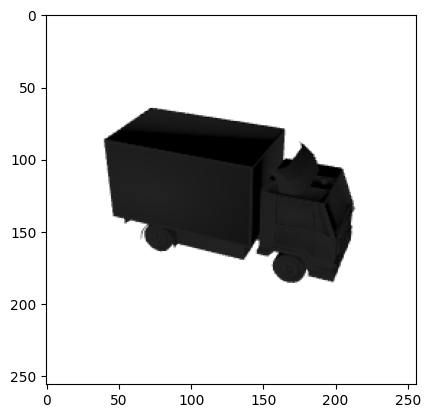

In [23]:
for i, ((images, _), (objects, _)) in enumerate(zip(dataloader, targetloader)):
    check_output(objects[0], images[0], epoch=2000, batch=2000)
    break

In [24]:
num_epochs = 300

Epoch [4/300], Step [1/1], Loss: 0.3543
Epoch [8/300], Step [1/1], Loss: 0.3523
0
Epoch [12/300], Step [1/1], Loss: 0.3515
Epoch [16/300], Step [1/1], Loss: 0.3506
Epoch [20/300], Step [1/1], Loss: 0.3498
0
Epoch [24/300], Step [1/1], Loss: 0.3547
Epoch [28/300], Step [1/1], Loss: 0.3542
0
Epoch [32/300], Step [1/1], Loss: 0.3465
Epoch [36/300], Step [1/1], Loss: 0.3447
Epoch [40/300], Step [1/1], Loss: 0.3434
0
Epoch [44/300], Step [1/1], Loss: 0.3456
Epoch [48/300], Step [1/1], Loss: 0.3418
0
Epoch [52/300], Step [1/1], Loss: 0.3400
Epoch [56/300], Step [1/1], Loss: 0.3418
Epoch [60/300], Step [1/1], Loss: 0.3368
0
Epoch [64/300], Step [1/1], Loss: 0.3333
Epoch [68/300], Step [1/1], Loss: 0.3537
0
Epoch [72/300], Step [1/1], Loss: 0.3329
Epoch [76/300], Step [1/1], Loss: 0.3287
Epoch [80/300], Step [1/1], Loss: 0.3339
0
Epoch [84/300], Step [1/1], Loss: 0.3242
Epoch [88/300], Step [1/1], Loss: 0.3209
17
Epoch [92/300], Step [1/1], Loss: 0.3176
Epoch [96/300], Step [1/1], Loss: 0.3183

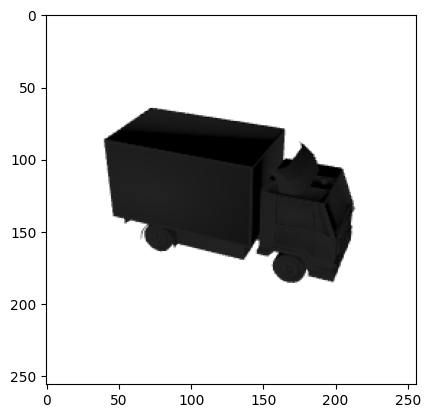

In [36]:
for epoch in range(num_epochs):
    try:
        for i, ((images, _), (objects, _)) in enumerate(zip(dataloader, targetloader)):
            # Move data to the appropriate device
            images = images.to(device)
            objects = objects.to(device)

            ### Train Generator
            optimizer.zero_grad()

            output = model(images).squeeze(1)
            loss = criterion(output, objects)
            loss.backward()

            optimizer.step()

            if (epoch + 1) % 4 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], '
                      f'Loss: {loss.item():.4f}')

            if (epoch + 1) % 10 == 0:
                # if (i + 1) % 5 == 0:
                try:
                    check_normal_output(output[0], images[0], epoch=epoch, batch=i)
                except Exception:
                    pass


        #     # check_output(fake_images[0], epoch)
        #     generate_and_plot_images(25, epoch=epoch)

        if (epoch + 1) % 90 == 0:
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch  # Optional, if you want to also save the epoch number
            }

            torch.save(checkpoint, f'GAN_ass_{epoch}.pth')

    except OSError:
        print(f"An error occurred while processing the image. Epoch: {epoch}, batch: {i}")
        continue


2001


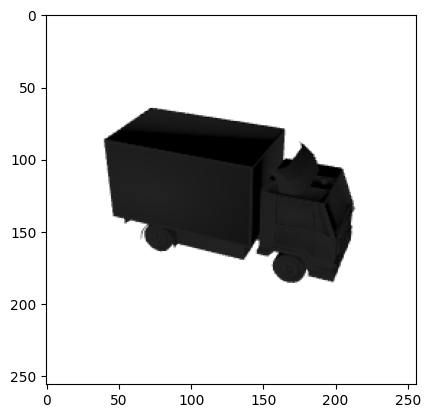

In [35]:
check_normal_output(output[0], images[0], threshold=float(output.median()), epoch=0, batch=0)

491


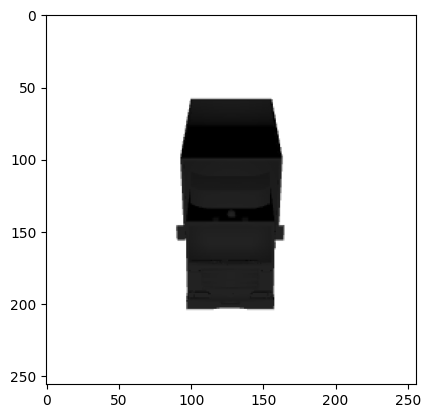

In [68]:
check_normal_output(output[0], images[0], epoch=epoch + 1, batch=i + 1)

2048


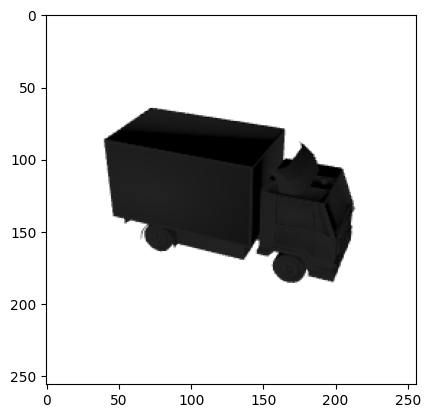

In [30]:
check_output(output[0], images[0], epoch=epoch, batch=i)

519


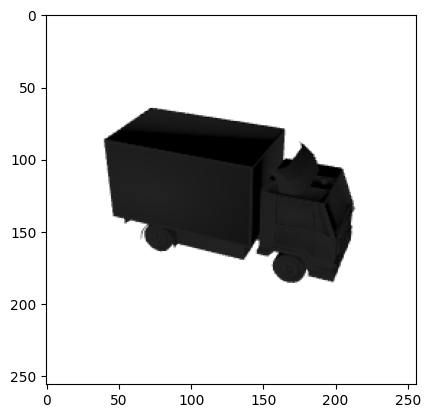

In [34]:
check_normal_output(model(images).squeeze(1)[0], images[0], threshold=0.5, epoch=1000, batch=1000)

In [34]:
model(images[1].unsqueeze(0).to(device)).shape

torch.Size([1, 1, 16, 16, 16])

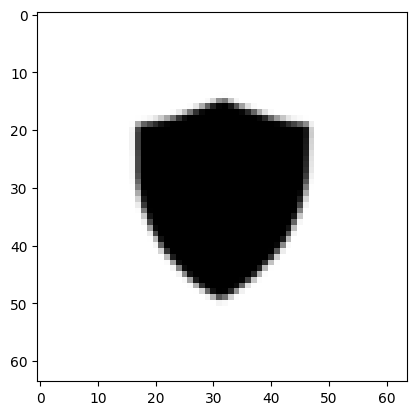

In [122]:
check_output(output[4], images[4], epoch=0)

In [123]:
output[4]

tensor([[[8.8006e-02, 2.0144e-01, 2.9009e-01,  ..., 8.9391e-02,
          7.4145e-02, 3.3514e-02],
         [1.3633e-01, 2.3901e-01, 2.7001e-01,  ..., 7.4983e-02,
          7.2419e-02, 3.8240e-02],
         [1.6877e-01, 2.6712e-01, 2.8253e-01,  ..., 6.7611e-02,
          9.0792e-02, 3.1234e-02],
         ...,
         [3.1964e-02, 5.0868e-02, 5.6639e-02,  ..., 3.3566e-04,
          1.1422e-03, 3.9571e-04],
         [2.1923e-02, 2.8927e-02, 4.5737e-02,  ..., 2.8116e-04,
          5.6690e-03, 5.9631e-03],
         [5.7261e-03, 1.4686e-02, 1.9347e-02,  ..., 2.8720e-04,
          4.6226e-03, 5.4296e-03]],

        [[9.8284e-02, 1.8116e-01, 2.5352e-01,  ..., 1.0125e-01,
          7.2335e-02, 3.6770e-02],
         [1.5201e-01, 2.3681e-01, 3.1123e-01,  ..., 9.2363e-02,
          7.7043e-02, 4.3951e-02],
         [1.8236e-01, 3.0570e-01, 2.8118e-01,  ..., 5.4563e-02,
          7.2248e-02, 3.4171e-02],
         ...,
         [2.5424e-02, 4.2590e-02, 6.6943e-02,  ..., 3.1306e-04,
          6.449

In [144]:
objects[0][0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 